# Discover

## Disable warnings

In [1]:
import warnings

warnings.simplefilter("ignore")

## Imports

In [2]:
import random
import PIL
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

2024-07-02 03:17:07.314392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 03:17:07.314511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 03:17:07.448284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Try small Sample

In [3]:
dataset_path = '/kaggle/input/artifact-dataset'
real_image_files = ["afhq", "celebahq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces"]

function to take a random sample from the dataset for the test

In [4]:
def random_sample(image_count, random_state):
    images_path = np.array([])
    images_label = np.array([])
    images_class = np.array([])
    
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        metadata_path = os.path.join(folder_path, 'metadata.csv')
        metadata_data_frame = pd.read_csv(metadata_path)
        sample_size = min(image_count,len(metadata_data_frame))
        sample = metadata_data_frame.sample(sample_size, random_state=random_state)
        images_path = np.append(images_path, sample['image_path'].apply( lambda x: os.path.join(folder_path, x) ))
        images_label = np.append(images_label, sample['target'].apply( lambda x: "Real" if folder in real_image_files else "Fake" )  )
        images_class = np.append(images_class, np.full(sample_size, "real" if folder in real_image_files else folder  ) )
    
    return images_path, images_label, images_class

function to get random sample as a dataframe

In [5]:
def random_dataframe(image_count=500, random_state=42):
    images_path, images_label, images_class = random_sample(image_count, random_state)
    sample = pd.DataFrame({
    'image_path': images_path,
    'label': images_label,
    'class': images_class
    })
    return sample

function to balance the classes in the dataframe

In [6]:
from sklearn.utils import resample

def balance_dataframe(df, random_state=42):
    min_class_size = sample['label'].value_counts().min()
    dfs = [df[df['label'] == label] for label in df['label'].unique()]
    
    balanced_df = [resample(d, replace=False, n_samples=min_class_size, random_state=random_state) for d in dfs]
    
    return pd.concat(balanced_df)

In [7]:
sample = random_dataframe(5000)
sample['label'].value_counts()

label
Fake    120896
Real     35654
Name: count, dtype: int64

In [8]:
sample = balance_dataframe(sample)
sample['label'].value_counts()

label
Fake    35654
Real    35654
Name: count, dtype: int64

In [9]:
# 0 real, 1 fake
sample

,image_path,label,class
135798,/kaggle/input/artifact-dataset/star_gan/star/s...,Fake,star_gan
98253,/kaggle/input/artifact-dataset/taming_transfor...,Fake,taming_transformer
67706,/kaggle/input/artifact-dataset/stylegan3/sg3/s...,Fake,stylegan3
44132,/kaggle/input/artifact-dataset/cycle_gan/st/ho...,Fake,cycle_gan
29383,/kaggle/input/artifact-dataset/mat/mat/landsca...,Fake,mat
...,...,...,...
117746,/kaggle/input/artifact-dataset/afhq/afhq/afhq_...,Real,real
41265,/kaggle/input/artifact-dataset/metfaces/metfac...,Real,real
56284,/kaggle/input/artifact-dataset/imagenet/imagen...,Real,real
35860,/kaggle/input/artifact-dataset/celebahq/celeba...,Real,real


split data into train and test

In [10]:
from sklearn.model_selection import train_test_split

train_sample, test_sample = train_test_split(sample, test_size=0.2, random_state=42, stratify=sample['label'])
train_sample

,image_path,label,class
110335,/kaggle/input/artifact-dataset/latent_diffusio...,Fake,latent_diffusion
91373,/kaggle/input/artifact-dataset/lsun/cat/cat/im...,Real,real
39346,/kaggle/input/artifact-dataset/celebahq/celeba...,Real,real
92666,/kaggle/input/artifact-dataset/lsun/horse/hors...,Real,real
84121,/kaggle/input/artifact-dataset/pro_gan/pro/din...,Fake,pro_gan
...,...,...,...
155399,/kaggle/input/artifact-dataset/landscape/lands...,Real,real
51765,/kaggle/input/artifact-dataset/imagenet/imagen...,Real,real
130096,/kaggle/input/artifact-dataset/ffhq/ffhq/image...,Real,real
141046,/kaggle/input/artifact-dataset/coco/coco/coco2...,Real,real


In [11]:
image_height = 200
image_width = 200
batch_size = 32

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(rescale=1./255,
                                horizontal_flip=True,
                                rotation_range=20,
                                zoom_range=0.1,
                                fill_mode='nearest',
                                validation_split=0.2)

test_data_generator = ImageDataGenerator(rescale=1./255)

In [13]:
train_set = train_data_generator.flow_from_dataframe(
    dataframe=train_sample,
    x_col='image_path',
    y_col='label',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_set = train_data_generator.flow_from_dataframe(
    dataframe=train_sample,
    x_col='image_path',
    y_col='label',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_set = test_data_generator.flow_from_dataframe(
    dataframe=test_sample,
    x_col='image_path',
    y_col='label',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 45637 validated image filenames belonging to 2 classes.
Found 11409 validated image filenames belonging to 2 classes.
Found 14262 validated image filenames belonging to 2 classes.


In [14]:
def plot_images(images, labels, name, num_images=16):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title( "Real" if np.argmax(labels[i]) == 0 else "Fake" )
        plt.axis("off")
    plt.savefig(name+'.png')
    plt.show()

### Visualize images 

Train set

Training set samples:


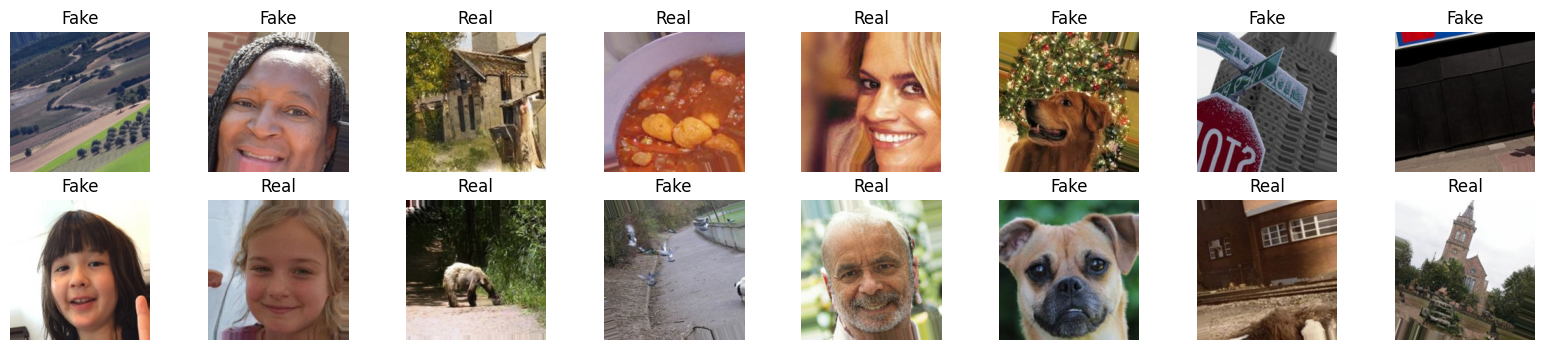

In [15]:
train_images, train_labels = next(train_set)

print("Training set samples:")
plot_images(train_images, train_labels, 'train')

Validation set

Validation set samples:


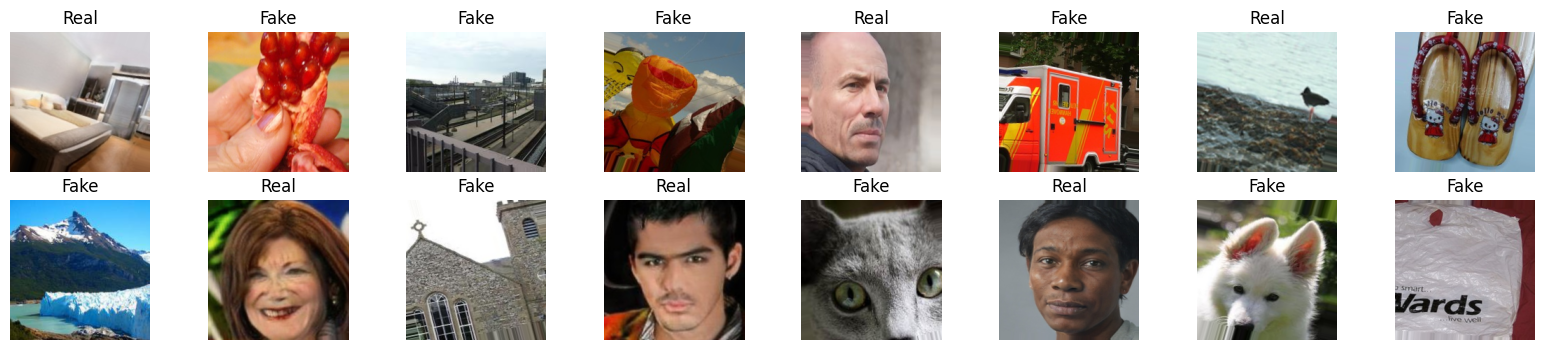

In [16]:
val_images, val_labels = next(validation_set)

print("Validation set samples:")
plot_images(val_images, val_labels, 'validation')

Test set

Test set samples:


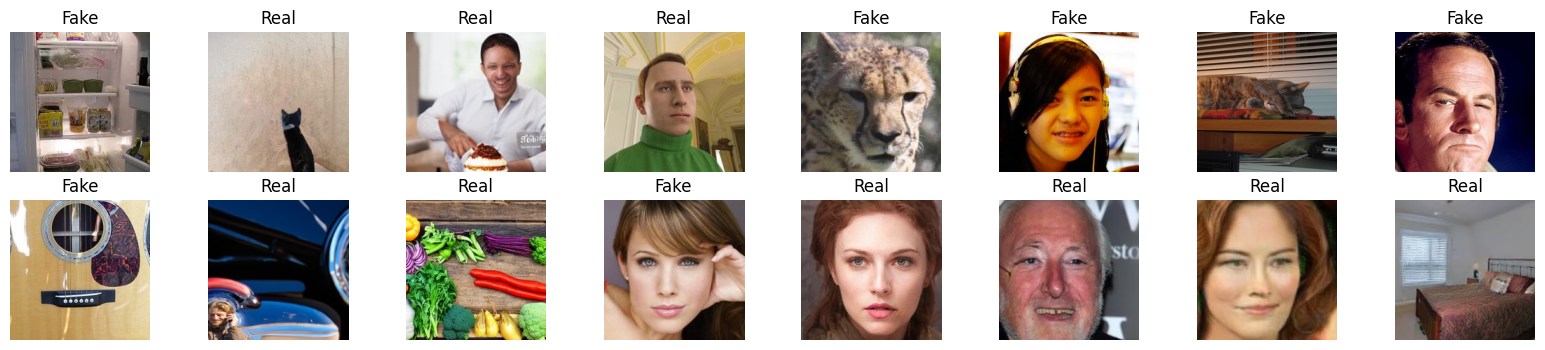

In [17]:
test_images, test_labels = next(test_set)

print("Test set samples:")
plot_images(test_images, test_labels, 'test')

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = Sequential([
  Resizing(image_height, image_width),
  Rescaling(1./255),
])


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

model = Sequential([
    resize_and_rescale,
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    
    GlobalAveragePooling2D(),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    Dense(2, activation='softmax')
])



model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(train_set,
                    validation_data=validation_set,
                    verbose=2,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/100


2024-07-02 03:22:48.424886: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65: 5.41783, expected 4.72242
2024-07-02 03:22:48.424954: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 66: 4.33458, expected 3.63917
2024-07-02 03:22:48.424965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 141: 5.05684, expected 4.36143
2024-07-02 03:22:48.424974: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 142: 5.83136, expected 5.13595
2024-07-02 03:22:48.424983: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 143: 5.29561, expected 4.6002
2024-07-02 03:22:48.424992: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 216: 5.34702, expected 4.65161
2024-07-02 03:22:48.425001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 264: 5.29538, expected 4.59997
2024-07-02 03:22:48.425010: E external/local

1427/1427 - 874s - 613ms/step - accuracy: 0.5669 - loss: 0.6916 - val_accuracy: 0.4979 - val_loss: 3.0178
Epoch 2/100
1427/1427 - 547s - 383ms/step - accuracy: 0.6261 - loss: 0.6463 - val_accuracy: 0.5382 - val_loss: 0.8326
Epoch 3/100
1427/1427 - 538s - 377ms/step - accuracy: 0.6506 - loss: 0.6272 - val_accuracy: 0.5297 - val_loss: 0.8878
Epoch 4/100
1427/1427 - 551s - 386ms/step - accuracy: 0.6565 - loss: 0.6199 - val_accuracy: 0.5073 - val_loss: 1.6464
Epoch 5/100
1427/1427 - 553s - 387ms/step - accuracy: 0.6653 - loss: 0.6157 - val_accuracy: 0.5073 - val_loss: 1.1477
Epoch 6/100
1427/1427 - 555s - 389ms/step - accuracy: 0.6739 - loss: 0.6057 - val_accuracy: 0.5790 - val_loss: 1.1625
Epoch 7/100
1427/1427 - 540s - 379ms/step - accuracy: 0.6740 - loss: 0.6015 - val_accuracy: 0.6301 - val_loss: 0.6571
Epoch 8/100
1427/1427 - 536s - 376ms/step - accuracy: 0.6837 - loss: 0.5943 - val_accuracy: 0.5037 - val_loss: 2.4400
Epoch 9/100
1427/1427 - 539s - 378ms/step - accuracy: 0.6839 - loss:

In [22]:
loss, accuracy = model.evaluate(test_set)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

445/446 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.5804 - loss: 0.7672

2024-07-02 06:04:58.248915: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 6.28607, expected 5.46743
2024-07-02 06:04:58.249003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.85068, expected 5.03204
2024-07-02 06:04:58.249013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04224, expected 5.2236
2024-07-02 06:04:58.249022: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.36704, expected 5.5484
2024-07-02 06:04:58.249030: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.87554, expected 5.0569
2024-07-02 06:04:58.249038: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.11336, expected 6.29472
2024-07-02 06:04:58.249046: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.27543, expected 5.45679
2024-07-02 06:04:58.249054: E external/local_xla/xla/servi

446/446 ━━━━━━━━━━━━━━━━━━━━ 123s 276ms/step - accuracy: 0.5804 - loss: 0.7672
Validation Accuracy: 57.80%


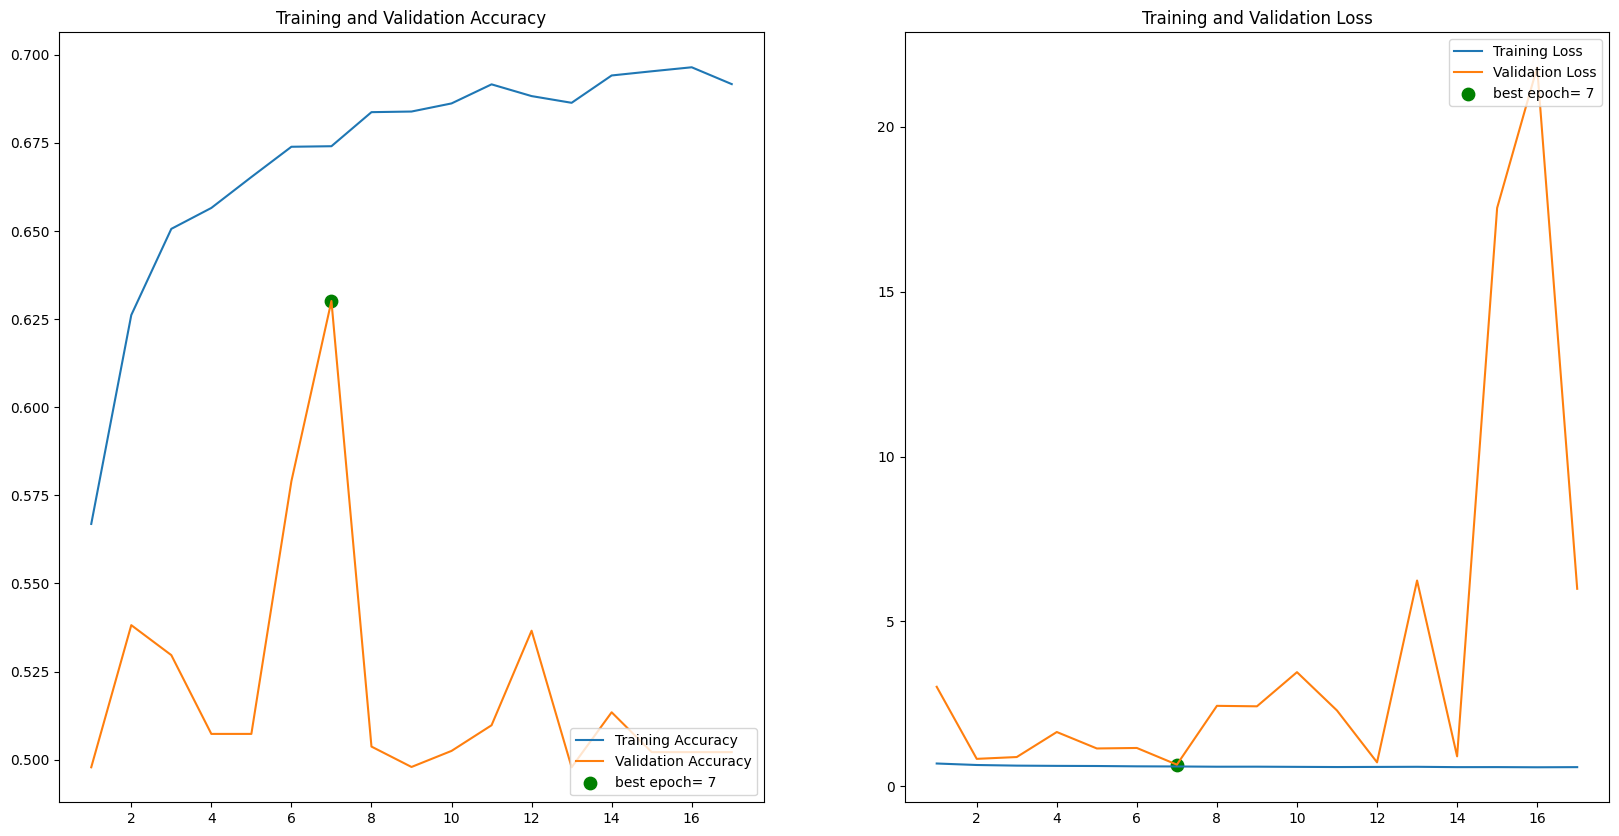

In [23]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

epochs_range = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, tr_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.scatter(index_acc+1, acc_highest, s=80, c='green', label= acc_label)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, tr_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.scatter(index_loss+1, val_lowest, s=80, c='green', label= loss_label)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('metrics_plot.jpg')
plt.show()

In [24]:
model.save('custom_cnn_model.h5')